In [220]:
import pandas as pd
from matplotlib import pyplot as plt
from textwrap import wrap
    
df = pd.read_csv('../rotten_tomatoes_critic_reviews.csv')
df2 = df[~df.review_score.isna()]
df2 = df2.drop_duplicates(subset=['review_score'])

score_labels = ["VERY_BAD", "BAD", "MID", "GOOD", "VERY_GOOD"]
score_letters = ['E', 'D', 'C', 'B', 'A']
review_score_label = []

def is_it_number_score(score):
    for char in score:
        if char.isalpha():
            return False
    return True

def get_label_from_score_ratio(score):
    index = score.find('/')
    numerator = score[0:index]
    denominator = score[(index + 1):]
    if float(denominator) <= 0:
        return score_labels[0]
    res = (float(numerator)/float(denominator)) * 5
    rounded_res = round(res)
    if rounded_res / 5 > 1:
        rounded_res = 5
    if rounded_res != 0:
        rounded_res -= 1
    return score_labels[rounded_res]

def get_label_from_score_letter(score):
    letter = score[0]
    count = 0
    for score_letter in score_letters:
        if score_letter == letter:
            return score_labels[count]
        count += 1
    return score_labels[0]
    

for score in df2["review_score"]:
    if is_it_number_score(score):
        if score.find('/') >= 0:
            review_score_label.append(get_label_from_score_ratio(score))
        else:
            review_score_label.append(get_label_from_score_ratio(score + '/100'))
    else:
        review_score_label.append(get_label_from_score_letter(score))

df2["review_score_label"] = review_score_label

In [224]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_TFIDF_by_review_score_label(dataset):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform(dataset)
    df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    return df.head(50)

df3 = pd.DataFrame(columns=["tf-idf", "review_content"], index=["VERY_BAD", "BAD", "MID", "GOOD", "VERY_GOOD"]) 

for index, row in df3.iterrows():
    df3.at[index, "review_content"] = (df2[df2.review_score_label == index]["review_content"]).array
    df3.at[index, "tf-idf"] = get_TFIDF_by_review_score_label(df3.at[index, "review_content"].astype('U'))

    # review_by_score[label]["review_content"] = df2[df2.review_score_label == label]["review_content"]
    # review_by_score[label]["tfidf"] = get_TFIDF_by_review_score_label(
    #     (review_by_score[label]["review_content"]).values.astype('U'))

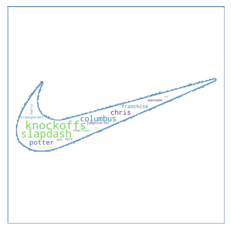

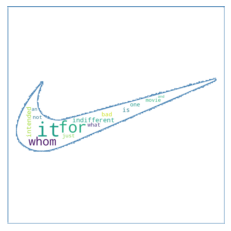

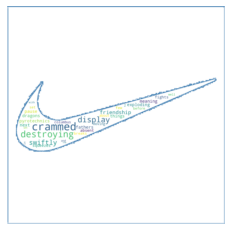

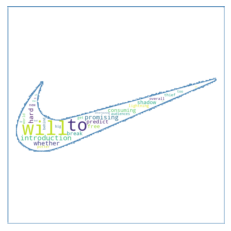

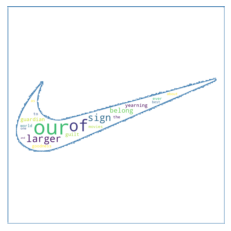

In [231]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image

def makeImage(tfidf):
    mask_path = "nike.jpg"
    #wordcloud part
    stopwords = set(STOPWORDS)
    stopwords.add("said")   
    mask = np.array(Image.open(mask_path))
    d = {}
    for word, freq in tfidf.iterrows():
        d[word] = tfidf.at[word, "TF-IDF"]
    # wc = WordCloud(background_color="white", max_words=2000,
    #            stopwords=stopwords, contour_width=3, contour_color='steelblue')
    wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')
    wc.generate_from_frequencies(d)
    # wc.to_file("word_cloud_" + mask_path)
    #matplotlib part
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


makeImage(df3.at["VERY_BAD", "tf-idf"])
makeImage(df3.at["BAD", "tf-idf"])
makeImage(df3.at["MID", "tf-idf"])
makeImage(df3.at["GOOD", "tf-idf"])
makeImage(df3.at["VERY_GOOD", "tf-idf"])